http://ochearno.net/kaggle_house_prices_benchmark-2

### 1.データ分析の目的
<p>まず今回のデータ分析の目的を確認します。<br />
家を買うときに何LDKなのか、何坪なのかといったデータはもちろん不動産価格に影響するでしょう。</p>
<p>しかし今回はそれら以外にも多くの要因が不動産価格に影響することを確認します。<br />
具体的には79の変数を元に、不動産価格を予測することになります。データはアメリカ合衆国アイオワ州エイムズの不動産です。</p>


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

### 2.データセットについて
<p>SalePriceが予測したい不動産価格で、それら以外に1階の広さや地下の天井の高さ、基礎の種類からプールの有無まで多数の特徴量が含まれています。<br />
全部が全部不動産に影響することはないでしょうが、常識的には部屋の広さ、高さ、築年数などは大きく影響するはずです。<br />
特徴量としては面積のように連続値のものもあれば、品質のようなカテゴリカル変数も存在しています。</p>
<p>まずは特徴量同士のデータ可視化や外れ値の処理などは行いません。<br />
79もの特徴量があるため、いくつか重要と考えられる変数だけ抽出したとしてもそこには主観が入ってしまいます。<br />
例えばSalePriceと1回の広さ1stFlrSFをプロットして、外れている点を削除するというのも単変量しか見ておらず、特徴量同士の相互作用を考慮できていません。</p>
<p>データはtrain.csvとtest.csvに分かれており、またKaggleにアップロードする際の形式としてsample_submission.csvが用意されています。<br />
データの説明(Data_Description.txt)も用意されており、必ず読む必要があります。79変数あるのでここでは省きますが、欠損値の補完ですぐに必要になります。</p>


In [2]:
#学習データとテストデータの読み込み
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")
#予測に使わないIdを保持・データフレームから削除
df_train_index = df_train["Id"]
df_test_index = df_test["Id"]
df_train.drop(["Id"], axis=1, inplace=True)
df_test.drop(["Id"], axis=1, inplace=True)

In [3]:
#目的変数であるSalePriceを別に取っておく
y_train = df_train["SalePrice"].values
df_train.drop(["SalePrice"], axis=1, inplace=True)
#学習用データとテストデータを一度統合する
df_all = pd.concat((df_train,df_test)).reset_index(drop=True)

In [4]:
#データ数
print(df_train.shape)
print(df_test.shape)

(1460, 79)
(1459, 79)


### 3.欠損値の補完

In [5]:
#欠損値の個数確認 / 2919データ
df_all.isnull().sum()[df_all.isnull().sum() != 0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

In [6]:
print(df_all["PoolQC"].dtype)

object


In [7]:
print(df_all["MiscFeature"].dtype)

object


In [8]:
print(df_all["GarageYrBlt"].dtype)

float64


In [9]:
#欠損値の補完
#以下はNaN = NAかNoneの特徴量リスト。よって欠損値をそれぞれNAとNoneで補完する。
df_all["PoolQC"].fillna('NA', inplace=True)
df_all["MiscFeature"].fillna('None', inplace=True)
df_all["Alley"].fillna('NA', inplace=True)
df_all["Fence"].fillna('NA', inplace=True)
df_all["FireplaceQu"].fillna('NA', inplace=True)
df_all["GarageQual"].fillna('NA', inplace=True)
df_all["GarageFinish"].fillna('NA', inplace=True)
df_all["GarageCond"].fillna('NA', inplace=True)
df_all["GarageType"].fillna('NA', inplace=True)
df_all["BsmtCond"].fillna('NA', inplace=True)
df_all["BsmtExposure"].fillna('NA', inplace=True)
df_all["BsmtQual"].fillna('NA', inplace=True)
df_all["BsmtFinType2"].fillna('NA', inplace=True)
df_all["BsmtFinType1"].fillna('NA', inplace=True)
df_all["MasVnrType"].fillna('None', inplace=True)
#以下はNaN = 0の特徴量リスト。例えば地下なら、地下がないんだから0。みたいな。
df_all["GarageYrBlt"].fillna(0, inplace=True) # ガレージ築年数を0にするのも不思議な気はしますが、そもそもガレージがないので他に妥当な数字が思いつかず。
df_all["MasVnrArea"].fillna(0, inplace=True)
df_all["BsmtHalfBath"].fillna(0, inplace=True)
df_all["BsmtFullBath"].fillna(0, inplace=True)
df_all["TotalBsmtSF"].fillna(0, inplace=True)
df_all["BsmtUnfSF"].fillna(0, inplace=True)
df_all["BsmtFinSF2"].fillna(0, inplace=True)
df_all["BsmtFinSF1"].fillna(0, inplace=True)
df_all["GarageArea"].fillna(0, inplace=True)
df_all["GarageCars"].fillna(0, inplace=True)
#欠損レコード数が少なく、大半が一つの値をとっているためあまりに予測の役に立たなさそうな特徴量は単純に最頻値を代入
df_all["MSZoning"].fillna('RL', inplace=True)
df_all["Functional"].fillna('Typ', inplace=True)
df_all["Utilities"].fillna("AllPub", inplace=True)
df_all['SaleType'] = df_all['SaleType'].fillna(df_all['SaleType'].mode()[0])
df_all['Exterior2nd'] = df_all['Exterior2nd'].fillna(df_all['Exterior2nd'].mode()[0])
df_all['Exterior1st'] = df_all['Exterior1st'].fillna(df_all['Exterior1st'].mode()[0])
df_all['KitchenQual'] = df_all['KitchenQual'].fillna(df_all['KitchenQual'].mode()[0])
df_all['Electrical'] = df_all['Electrical'].fillna(df_all['Electrical'].mode()[0])
#LotFrontage - Linear feet of street connected to property
#これは補完方法が明らかかつ簡単で、近くのStreet名=Neighborhoodでグループし平均を取れば良い精度で補完できそう。
f = lambda x: x.fillna(x.mean())
df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(f)

In [10]:
#欠損値がすべて補完されているか確認
df_all.isnull().sum()[df_all.isnull().sum() != 0].sort_values(ascending=False)

Series([], dtype: int64)

### 4.前処理

#### カテゴリー変数処理

In [11]:
#One Hot Encodingでダミー変数化
df_all = pd.get_dummies(df_all)
#特徴量数の確認
df_all.shape

(2919, 302)

#### Feature Engineering

In [12]:
#日本人なら気になる、「で、何LDKなの？」
df_all['xLDK'] = df_all['BedroomAbvGr'] + df_all['KitchenAbvGr']
#何年に建ったかより、築年数の方が重要のはず
df_all['YearSinceBuilt'] = 2018 - df_all['YearBuilt']
#何年に売れたかより、売れてから経過している年数の方が重要のはず
df_all['YrSinceSold'] = 2018 - df_all['YrSold']
#ガレージの築年数
df_all['GarageSinceYrBlt'] = 2018 - df_all['GarageYrBlt']
#大きなくくりで集計してみる
df_all['TotalHousePorchSF'] = df_all['EnclosedPorch'] + df_all['OpenPorchSF'] + df_all['WoodDeckSF']+df_all['3SsnPorch']+df_all['ScreenPorch']
df_all['TotalHouseSF'] = df_all['1stFlrSF'] + df_all['2ndFlrSF'] + df_all['TotalBsmtSF']
#なんかLow Qualityな面積があるらしいので全体の面積から引く
df_all['TotalHouseSFHighQuality'] = df_all['TotalHouseSF'] - df_all['LowQualFinSF']
#割るぞ～
df_all['1stFlr_vs_2ndFlr'] = df_all['1stFlrSF'] / (df_all['2ndFlrSF'] + 0.001)
df_all['Bsmt_vs_1stAnd2ndFlr'] = df_all['TotalBsmtSF'] / (df_all['1stFlrSF'] + df_all['2ndFlrSF'] + 0.001)
#Overall Qualityが結構重要そうなので2乗と3乗してみる
df_all['OverallQual_2'] = df_all['OverallQual']**2
df_all['OverallQual_3'] = df_all['OverallQual']**3

#### 外れ値処理
<p>多変量の外れ値検知手法としてはModified Stahel Donoho法などいくつかの方法が知られています。<br />今回はIsolation Forestと呼ばれる手法を使って外れ値の存在を確かめたいと思います。</p>
<p>Isolation Forestは名前が示す通り決定木ベースの外れ値検知法で、特徴量をランダムに選び、決定境界を適当に何度も引きます。<br />
その後、あるサンプルを集団から分離させるのに必要だった分割回数(線を引いた回数)を利用して、外れ値を検出します。<br />
外れ値ほど分離しやすく分割回数は減り、データが密集している付近の値ほど分離しにくく分割回数が増えるという具合です。</p>
<p>決定木ベースなので、ランダムフォレストなどと同じく正規化等なくてもうまい具合に動いてくれる上、データが多次元正規分布に従っているなどの仮定も必要ないのでとても便利に扱えます。<br />

In [13]:
#学習用データとテストデータを切り分ける
ntrain = df_train.shape[0]
train = df_all[:ntrain]
test = df_all[ntrain:]
y = y_train
#X = train.loc[:, train.columns != 'SalePrice']

In [14]:
#Isolation Forest
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=1234,n_estimators=500, contamination=0.01)
clf.fit(train)

IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples='auto', n_estimators=500, n_jobs=1, random_state=1234,
        verbose=0)

In [15]:
mv_outliers = pd.DataFrame(clf.predict(train))
mv_outliers.columns = ['OutlierFlag']

Contaminationは外れ値の割合で、とりあえず1%にセット

In [16]:
mv_outliers[mv_outliers == -1].count()

OutlierFlag    15
dtype: int64

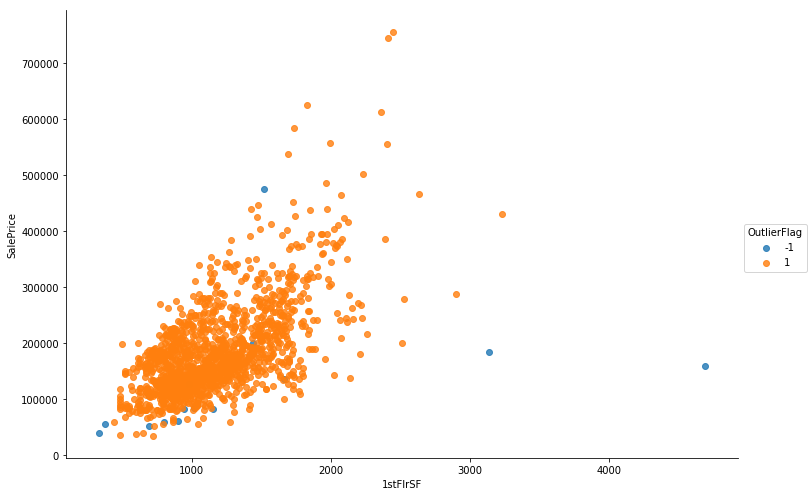

In [17]:
#SalesPriceと1階の広さ
y_train = pd.DataFrame(y_train)
y_train.columns = ['SalePrice']
df_all_olcheck = pd.concat([mv_outliers,train, y_train], axis=1)
ax = sns.lmplot(x='1stFlrSF', y='SalePrice',fit_reg=False,
data=df_all_olcheck, hue='OutlierFlag', size=7, aspect=1.5)

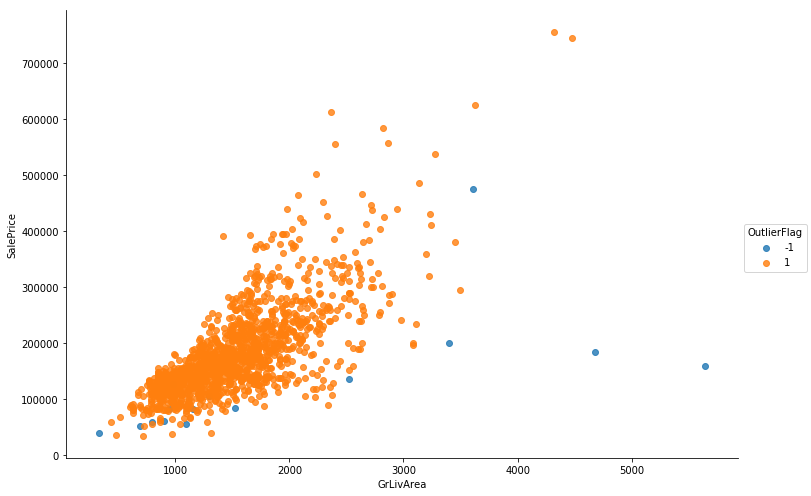

In [18]:
#SalesPriceとエリアの広さ
y_train = pd.DataFrame(y_train)
y_train.columns = ['SalePrice']
df_all_olcheck = pd.concat([mv_outliers,train, y_train], axis=1)
ax = sns.lmplot(x='GrLivArea', y='SalePrice',fit_reg=False,
data=df_all_olcheck, hue='OutlierFlag', size=7, aspect=1.5)

In [19]:
#外れ値を取り除く
df_all_r1 = df_all_olcheck[df_all_olcheck['OutlierFlag'] == 1]
df_all_r1.drop("OutlierFlag", axis=1, inplace=True)
y_train_r1 = df_all_r1["SalePrice"].values
df_all_r1.drop(["SalePrice"], axis=1, inplace=True)
#30%でチューニングを行う
X_train, X_test, y_train, y_test = train_test_split(df_all_r1, y_train_r1, test_size=0.3, random_state=1234)

### 5.機械学習 

####  ランダムフォレスト

In [20]:
#モデルの呼び出し
rf = RandomForestRegressor()

In [21]:
#グリッドサーチ用パラメータの設定
rf_parameters= {'n_estimators':[100, 500, 2000], 'max_depth':[3, 5, 10]}
#グリッドサーチ
rf_gs = GridSearchCV(rf, rf_parameters)
rf_gs.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 10], 'n_estimators': [100, 500, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
rf_gs.best_estimator_.n_estimators

2000

In [23]:
rf = RandomForestRegressor(n_estimators = 2000, max_depth=10, random_state=1234)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

In [24]:
#RMSE
y_pred2 = rf.predict(X_test)
print("ランダムフォレストでのRMSE:",np.sqrt(mean_squared_error(y_test, y_pred2)))

ランダムフォレストでのRMSE: 24109.83473127609


#### xgboost 

In [25]:
import xgboost as xgb

In [26]:
xgb_reg = xgb.XGBRegressor(max_depth=5, n_estimators=500, subsample=0.8)
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [27]:
#RMSE
y_pred3 = xgb_reg.predict(X_test)
print("xgboostでのRMSE:",np.sqrt(mean_squared_error(y_test, y_pred3)))

xgboostでのRMSE: 21661.413821225764


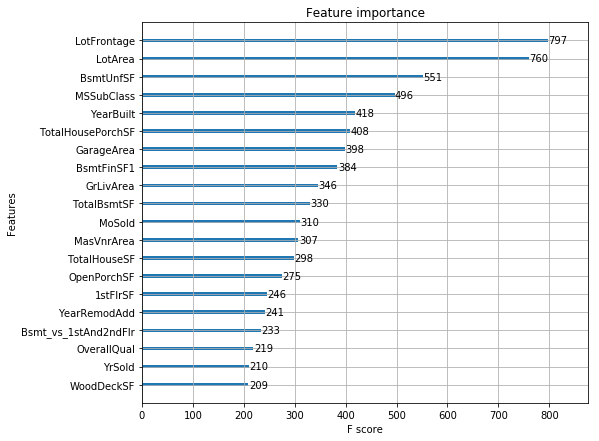

In [28]:
#特徴量
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(8,7))
plot_importance(xgb_reg, ax=ax, max_num_features=20)
plt.show()

#### SVR

In [29]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
scaler = MinMaxScaler()
X_train_svr = scaler.fit_transform(X_train)
X_test_svr = scaler.transform(X_test)
#SVR
svr = svm.SVR(C=1e6,epsilon=0.2,kernel='rbf')
svr.fit(X_train_svr, y_train)
#RMSE
y_pred = svr.predict(X_test_svr)
print("SVRでのRMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

SVRでのRMSE: 19752.221248069323


#### LightGBM

In [30]:
import lightgbm as lgb

In [31]:
lgb_train = lgb.Dataset(X_train,y_train)
lgb_eval = lgb.Dataset(X_test,y_test)

In [32]:
params = {
'task': 'train',
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': {'l2'},
'num_leaves': 256,
'learning_rate': 0.005,
'num_iterations':3000,
'feature_fraction': 0.4,
'bagging_fraction': 0.7,
'bagging_freq': 5,
}
gbm = lgb.train(params,lgb_train,num_boost_round=1500,valid_sets=lgb_eval)
y_test_pred_lgb = gbm.predict(np.array(X_test), num_iteration=gbm.best_iteration)
#RMSE
print("LightGBMでのRMSE:",np.sqrt(mean_squared_error(y_test, y_test_pred_lgb)))

[1]	valid_0's l2: 5.45613e+09
[2]	valid_0's l2: 5.415e+09
[3]	valid_0's l2: 5.37906e+09
[4]	valid_0's l2: 5.33774e+09
[5]	valid_0's l2: 5.29405e+09
[6]	valid_0's l2: 5.24881e+09
[7]	valid_0's l2: 5.20851e+09
[8]	valid_0's l2: 5.17332e+09
[9]	valid_0's l2: 5.12988e+09
[10]	valid_0's l2: 5.08888e+09
[11]	valid_0's l2: 5.04899e+09
[12]	valid_0's l2: 5.007e+09
[13]	valid_0's l2: 4.96531e+09
[14]	valid_0's l2: 4.93026e+09
[15]	valid_0's l2: 4.89201e+09
[16]	valid_0's l2: 4.84868e+09
[17]	valid_0's l2: 4.80653e+09
[18]	valid_0's l2: 4.76448e+09
[19]	valid_0's l2: 4.72175e+09
[20]	valid_0's l2: 4.6813e+09
[21]	valid_0's l2: 4.64115e+09
[22]	valid_0's l2: 4.60486e+09
[23]	valid_0's l2: 4.56915e+09
[24]	valid_0's l2: 4.53141e+09
[25]	valid_0's l2: 4.49384e+09
[26]	valid_0's l2: 4.45871e+09
[27]	valid_0's l2: 4.42374e+09
[28]	valid_0's l2: 4.39045e+09
[29]	valid_0's l2: 4.35687e+09
[30]	valid_0's l2: 4.32269e+09
[31]	valid_0's l2: 4.28816e+09
[32]	valid_0's l2: 4.2538e+09
[33]	valid_0's l2: 4.22

[350]	valid_0's l2: 7.64249e+08
[351]	valid_0's l2: 7.62193e+08
[352]	valid_0's l2: 7.59967e+08
[353]	valid_0's l2: 7.57878e+08
[354]	valid_0's l2: 7.55648e+08
[355]	valid_0's l2: 7.5354e+08
[356]	valid_0's l2: 7.51491e+08
[357]	valid_0's l2: 7.49782e+08
[358]	valid_0's l2: 7.48086e+08
[359]	valid_0's l2: 7.46443e+08
[360]	valid_0's l2: 7.44718e+08
[361]	valid_0's l2: 7.42955e+08
[362]	valid_0's l2: 7.41331e+08
[363]	valid_0's l2: 7.39355e+08
[364]	valid_0's l2: 7.38012e+08
[365]	valid_0's l2: 7.36444e+08
[366]	valid_0's l2: 7.34896e+08
[367]	valid_0's l2: 7.33008e+08
[368]	valid_0's l2: 7.31245e+08
[369]	valid_0's l2: 7.29171e+08
[370]	valid_0's l2: 7.27287e+08
[371]	valid_0's l2: 7.25547e+08
[372]	valid_0's l2: 7.2365e+08
[373]	valid_0's l2: 7.21537e+08
[374]	valid_0's l2: 7.1993e+08
[375]	valid_0's l2: 7.1824e+08
[376]	valid_0's l2: 7.16644e+08
[377]	valid_0's l2: 7.15413e+08
[378]	valid_0's l2: 7.14106e+08
[379]	valid_0's l2: 7.12482e+08
[380]	valid_0's l2: 7.10886e+08
[381]	valid_

[673]	valid_0's l2: 5.18649e+08
[674]	valid_0's l2: 5.18401e+08
[675]	valid_0's l2: 5.1842e+08
[676]	valid_0's l2: 5.18425e+08
[677]	valid_0's l2: 5.18134e+08
[678]	valid_0's l2: 5.17978e+08
[679]	valid_0's l2: 5.17636e+08
[680]	valid_0's l2: 5.17396e+08
[681]	valid_0's l2: 5.17046e+08
[682]	valid_0's l2: 5.16988e+08
[683]	valid_0's l2: 5.17025e+08
[684]	valid_0's l2: 5.16946e+08
[685]	valid_0's l2: 5.17056e+08
[686]	valid_0's l2: 5.166e+08
[687]	valid_0's l2: 5.1623e+08
[688]	valid_0's l2: 5.16106e+08
[689]	valid_0's l2: 5.15839e+08
[690]	valid_0's l2: 5.1556e+08
[691]	valid_0's l2: 5.15169e+08
[692]	valid_0's l2: 5.14819e+08
[693]	valid_0's l2: 5.14519e+08
[694]	valid_0's l2: 5.14235e+08
[695]	valid_0's l2: 5.13924e+08
[696]	valid_0's l2: 5.13726e+08
[697]	valid_0's l2: 5.13455e+08
[698]	valid_0's l2: 5.13478e+08
[699]	valid_0's l2: 5.13188e+08
[700]	valid_0's l2: 5.1289e+08
[701]	valid_0's l2: 5.12589e+08
[702]	valid_0's l2: 5.12355e+08
[703]	valid_0's l2: 5.12162e+08
[704]	valid_0'

[989]	valid_0's l2: 4.76526e+08
[990]	valid_0's l2: 4.76464e+08
[991]	valid_0's l2: 4.76556e+08
[992]	valid_0's l2: 4.76386e+08
[993]	valid_0's l2: 4.7628e+08
[994]	valid_0's l2: 4.76217e+08
[995]	valid_0's l2: 4.76058e+08
[996]	valid_0's l2: 4.76164e+08
[997]	valid_0's l2: 4.76329e+08
[998]	valid_0's l2: 4.76386e+08
[999]	valid_0's l2: 4.76137e+08
[1000]	valid_0's l2: 4.76295e+08
[1001]	valid_0's l2: 4.7609e+08
[1002]	valid_0's l2: 4.75715e+08
[1003]	valid_0's l2: 4.7564e+08
[1004]	valid_0's l2: 4.75683e+08
[1005]	valid_0's l2: 4.75806e+08
[1006]	valid_0's l2: 4.75763e+08
[1007]	valid_0's l2: 4.75603e+08
[1008]	valid_0's l2: 4.75378e+08
[1009]	valid_0's l2: 4.75313e+08
[1010]	valid_0's l2: 4.75097e+08
[1011]	valid_0's l2: 4.75e+08
[1012]	valid_0's l2: 4.75062e+08
[1013]	valid_0's l2: 4.74848e+08
[1014]	valid_0's l2: 4.74691e+08
[1015]	valid_0's l2: 4.74597e+08
[1016]	valid_0's l2: 4.74564e+08
[1017]	valid_0's l2: 4.74475e+08
[1018]	valid_0's l2: 4.7421e+08
[1019]	valid_0's l2: 4.73991

[1294]	valid_0's l2: 4.60776e+08
[1295]	valid_0's l2: 4.60937e+08
[1296]	valid_0's l2: 4.60929e+08
[1297]	valid_0's l2: 4.61007e+08
[1298]	valid_0's l2: 4.60969e+08
[1299]	valid_0's l2: 4.60899e+08
[1300]	valid_0's l2: 4.61048e+08
[1301]	valid_0's l2: 4.60838e+08
[1302]	valid_0's l2: 4.60706e+08
[1303]	valid_0's l2: 4.60585e+08
[1304]	valid_0's l2: 4.60461e+08
[1305]	valid_0's l2: 4.60336e+08
[1306]	valid_0's l2: 4.60331e+08
[1307]	valid_0's l2: 4.6018e+08
[1308]	valid_0's l2: 4.60216e+08
[1309]	valid_0's l2: 4.60266e+08
[1310]	valid_0's l2: 4.60365e+08
[1311]	valid_0's l2: 4.60632e+08
[1312]	valid_0's l2: 4.60812e+08
[1313]	valid_0's l2: 4.61071e+08
[1314]	valid_0's l2: 4.61249e+08
[1315]	valid_0's l2: 4.61182e+08
[1316]	valid_0's l2: 4.61093e+08
[1317]	valid_0's l2: 4.61089e+08
[1318]	valid_0's l2: 4.61071e+08
[1319]	valid_0's l2: 4.61059e+08
[1320]	valid_0's l2: 4.61064e+08
[1321]	valid_0's l2: 4.60953e+08
[1322]	valid_0's l2: 4.60798e+08
[1323]	valid_0's l2: 4.60629e+08
[1324]	vali

[1603]	valid_0's l2: 4.546e+08
[1604]	valid_0's l2: 4.54534e+08
[1605]	valid_0's l2: 4.54451e+08
[1606]	valid_0's l2: 4.54391e+08
[1607]	valid_0's l2: 4.54278e+08
[1608]	valid_0's l2: 4.5422e+08
[1609]	valid_0's l2: 4.5412e+08
[1610]	valid_0's l2: 4.54218e+08
[1611]	valid_0's l2: 4.54105e+08
[1612]	valid_0's l2: 4.53995e+08
[1613]	valid_0's l2: 4.53843e+08
[1614]	valid_0's l2: 4.53894e+08
[1615]	valid_0's l2: 4.53846e+08
[1616]	valid_0's l2: 4.53737e+08
[1617]	valid_0's l2: 4.53815e+08
[1618]	valid_0's l2: 4.53739e+08
[1619]	valid_0's l2: 4.53782e+08
[1620]	valid_0's l2: 4.53921e+08
[1621]	valid_0's l2: 4.53911e+08
[1622]	valid_0's l2: 4.53927e+08
[1623]	valid_0's l2: 4.53936e+08
[1624]	valid_0's l2: 4.53899e+08
[1625]	valid_0's l2: 4.54011e+08
[1626]	valid_0's l2: 4.53861e+08
[1627]	valid_0's l2: 4.53735e+08
[1628]	valid_0's l2: 4.53746e+08
[1629]	valid_0's l2: 4.53613e+08
[1630]	valid_0's l2: 4.5354e+08
[1631]	valid_0's l2: 4.53589e+08
[1632]	valid_0's l2: 4.53521e+08
[1633]	valid_0'

[1915]	valid_0's l2: 4.52672e+08
[1916]	valid_0's l2: 4.52582e+08
[1917]	valid_0's l2: 4.52423e+08
[1918]	valid_0's l2: 4.52509e+08
[1919]	valid_0's l2: 4.52353e+08
[1920]	valid_0's l2: 4.52201e+08
[1921]	valid_0's l2: 4.52305e+08
[1922]	valid_0's l2: 4.5228e+08
[1923]	valid_0's l2: 4.52384e+08
[1924]	valid_0's l2: 4.52505e+08
[1925]	valid_0's l2: 4.52639e+08
[1926]	valid_0's l2: 4.52637e+08
[1927]	valid_0's l2: 4.52523e+08
[1928]	valid_0's l2: 4.52509e+08
[1929]	valid_0's l2: 4.52491e+08
[1930]	valid_0's l2: 4.52457e+08
[1931]	valid_0's l2: 4.52522e+08
[1932]	valid_0's l2: 4.52597e+08
[1933]	valid_0's l2: 4.52596e+08
[1934]	valid_0's l2: 4.5267e+08
[1935]	valid_0's l2: 4.52674e+08
[1936]	valid_0's l2: 4.52666e+08
[1937]	valid_0's l2: 4.52518e+08
[1938]	valid_0's l2: 4.52544e+08
[1939]	valid_0's l2: 4.52494e+08
[1940]	valid_0's l2: 4.526e+08
[1941]	valid_0's l2: 4.5254e+08
[1942]	valid_0's l2: 4.52467e+08
[1943]	valid_0's l2: 4.52542e+08
[1944]	valid_0's l2: 4.52608e+08
[1945]	valid_0'

[2219]	valid_0's l2: 4.49823e+08
[2220]	valid_0's l2: 4.4977e+08
[2221]	valid_0's l2: 4.49823e+08
[2222]	valid_0's l2: 4.49747e+08
[2223]	valid_0's l2: 4.49735e+08
[2224]	valid_0's l2: 4.49751e+08
[2225]	valid_0's l2: 4.49714e+08
[2226]	valid_0's l2: 4.49721e+08
[2227]	valid_0's l2: 4.49705e+08
[2228]	valid_0's l2: 4.49701e+08
[2229]	valid_0's l2: 4.49675e+08
[2230]	valid_0's l2: 4.4966e+08
[2231]	valid_0's l2: 4.49671e+08
[2232]	valid_0's l2: 4.49649e+08
[2233]	valid_0's l2: 4.49802e+08
[2234]	valid_0's l2: 4.4976e+08
[2235]	valid_0's l2: 4.49715e+08
[2236]	valid_0's l2: 4.49653e+08
[2237]	valid_0's l2: 4.49642e+08
[2238]	valid_0's l2: 4.49609e+08
[2239]	valid_0's l2: 4.49546e+08
[2240]	valid_0's l2: 4.49573e+08
[2241]	valid_0's l2: 4.4965e+08
[2242]	valid_0's l2: 4.498e+08
[2243]	valid_0's l2: 4.49841e+08
[2244]	valid_0's l2: 4.49971e+08
[2245]	valid_0's l2: 4.50157e+08
[2246]	valid_0's l2: 4.50082e+08
[2247]	valid_0's l2: 4.49953e+08
[2248]	valid_0's l2: 4.4993e+08
[2249]	valid_0's 

[2518]	valid_0's l2: 4.47859e+08
[2519]	valid_0's l2: 4.47819e+08
[2520]	valid_0's l2: 4.47766e+08
[2521]	valid_0's l2: 4.47698e+08
[2522]	valid_0's l2: 4.47754e+08
[2523]	valid_0's l2: 4.47791e+08
[2524]	valid_0's l2: 4.4785e+08
[2525]	valid_0's l2: 4.47878e+08
[2526]	valid_0's l2: 4.47915e+08
[2527]	valid_0's l2: 4.47921e+08
[2528]	valid_0's l2: 4.47916e+08
[2529]	valid_0's l2: 4.47802e+08
[2530]	valid_0's l2: 4.47769e+08
[2531]	valid_0's l2: 4.478e+08
[2532]	valid_0's l2: 4.47891e+08
[2533]	valid_0's l2: 4.47922e+08
[2534]	valid_0's l2: 4.47888e+08
[2535]	valid_0's l2: 4.47929e+08
[2536]	valid_0's l2: 4.47838e+08
[2537]	valid_0's l2: 4.47777e+08
[2538]	valid_0's l2: 4.47676e+08
[2539]	valid_0's l2: 4.47632e+08
[2540]	valid_0's l2: 4.47521e+08
[2541]	valid_0's l2: 4.47504e+08
[2542]	valid_0's l2: 4.47484e+08
[2543]	valid_0's l2: 4.47488e+08
[2544]	valid_0's l2: 4.47501e+08
[2545]	valid_0's l2: 4.47472e+08
[2546]	valid_0's l2: 4.47529e+08
[2547]	valid_0's l2: 4.47619e+08
[2548]	valid_

[2814]	valid_0's l2: 4.47033e+08
[2815]	valid_0's l2: 4.47111e+08
[2816]	valid_0's l2: 4.47105e+08
[2817]	valid_0's l2: 4.47106e+08
[2818]	valid_0's l2: 4.47133e+08
[2819]	valid_0's l2: 4.47144e+08
[2820]	valid_0's l2: 4.47142e+08
[2821]	valid_0's l2: 4.47121e+08
[2822]	valid_0's l2: 4.47103e+08
[2823]	valid_0's l2: 4.47094e+08
[2824]	valid_0's l2: 4.47052e+08
[2825]	valid_0's l2: 4.46963e+08
[2826]	valid_0's l2: 4.47006e+08
[2827]	valid_0's l2: 4.46963e+08
[2828]	valid_0's l2: 4.46898e+08
[2829]	valid_0's l2: 4.46842e+08
[2830]	valid_0's l2: 4.46826e+08
[2831]	valid_0's l2: 4.46887e+08
[2832]	valid_0's l2: 4.46968e+08
[2833]	valid_0's l2: 4.46975e+08
[2834]	valid_0's l2: 4.47056e+08
[2835]	valid_0's l2: 4.47157e+08
[2836]	valid_0's l2: 4.47129e+08
[2837]	valid_0's l2: 4.47083e+08
[2838]	valid_0's l2: 4.4701e+08
[2839]	valid_0's l2: 4.4695e+08
[2840]	valid_0's l2: 4.46931e+08
[2841]	valid_0's l2: 4.46949e+08
[2842]	valid_0's l2: 4.46993e+08
[2843]	valid_0's l2: 4.46999e+08
[2844]	valid

#### ラッソ回帰

In [33]:
lasso = Lasso(normalize=True, random_state=123, max_iter=10000)
lasso.fit(X_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=False, random_state=123,
   selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
#RMSE
y_pred4 = lasso.predict(X_test)
print("LassoでのRMSE:",np.sqrt(mean_squared_error(y_test, y_pred4)))

LassoでのRMSE: 21573.46117467376


### 6.スタッキング
<p>スタッキングはアンサンブル学習の一種とも考えられ、複数の学習器を組み合わせて予測を行うことです。</p>
<p>具体的には予測を段階にわけて、第一段階は各種機械学習のアルゴリズムを出力し、第二段階の入力としてその出力を別の機械学習アルゴリズムに流し込んで予測するという具合です。<br />
第二段階は機械学習アルゴリズムを通しても良いし、単に平均、多数決、重み付けなどでも問題ないようです。</p>
<p>スタッキングで精度が上がる理由としては、それぞれの学習器とチューニングによるバイアスとバリアンスがうまいことならされる・・・ことかなと考えますが、アンサンブル学習の弱学習器が強い奴になった感じというざっくり理解で使います。</p>

学習用データを使って、それぞれの結果をどれぐらいの割合で混ぜるのが良いか確認

#### SVR xgboost Lasso

In [35]:
#SVRはy_pred, xgboostはy_pred3, Lassoはy_pred4
y_stack = y_pred*(1/3) + y_pred3*(1/3) + y_pred4*(1/3)
print("StackingでのRMSE:",np.sqrt(mean_squared_error(y_test, y_stack)))

StackingでのRMSE: 18586.943248473865


#### xgboost SVR LightGBM

In [36]:
y_stack = y_pred3*0.2+y_pred*0.55+y_test_pred_lgb*0.25
print("StackingでのRMSE:",np.sqrt(mean_squared_error(y_test, y_stack)))

StackingでのRMSE: 18553.845469926622


### 7.回帰分析の基礎に立ち返り

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [38]:
#データの読み込み
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
#外れ値の処理
df_train = df_train[~((df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000))]
#Id及びSaleprice以外の全データを結合(左端=Id, 右端はSalePrice)
df_all = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'], df_test.loc[:,'MSSubClass':'SaleCondition']))
#Feature Engineering - 前回の中で断トツでFeature Importanceが高かったTotalHousePorchSFを採用
df_all['TotalHousePorchSF'] = df_all['EnclosedPorch']+df_all['OpenPorchSF']+df_all['WoodDeckSF']+df_all['3SsnPorch']+df_all['ScreenPorch']
df_train['TotalHousePorchSF'] = df_train['EnclosedPorch']+df_train['OpenPorchSF']+df_train['WoodDeckSF']+df_train['3SsnPorch']+df_train['ScreenPorch']

<p>線形回帰分析を行う上で、残差の正規性や多重共線性の有無、説明変数ができるだけ正規分布している、線形の関係性があるなど気にすることがあります。<br />
L1正則化項の存在で回帰係数が不安定になりづらいとはいえ、多重共線性の有無、説明変数・目的変数の分布の正規化ぐらいはやっておこうと思います。<br />
尚、不動産価格に対して各種特徴量が概ね線形を保っているのはHouse Pricesについては自明なので、特に触れません。</p>
<h3 id="outline__3">多重共線性の確認</h3>
<p>多重共線性を確認する方法はVIFや相関係数行列を目視するなどいくつかあります。<br />
今回は相関係数行列を適当に眺めて相関が高い奴(0.8+)を省きます。カテゴリカル変数の共線性の評価はかなり複雑になるのでやりません&#8230;</p>


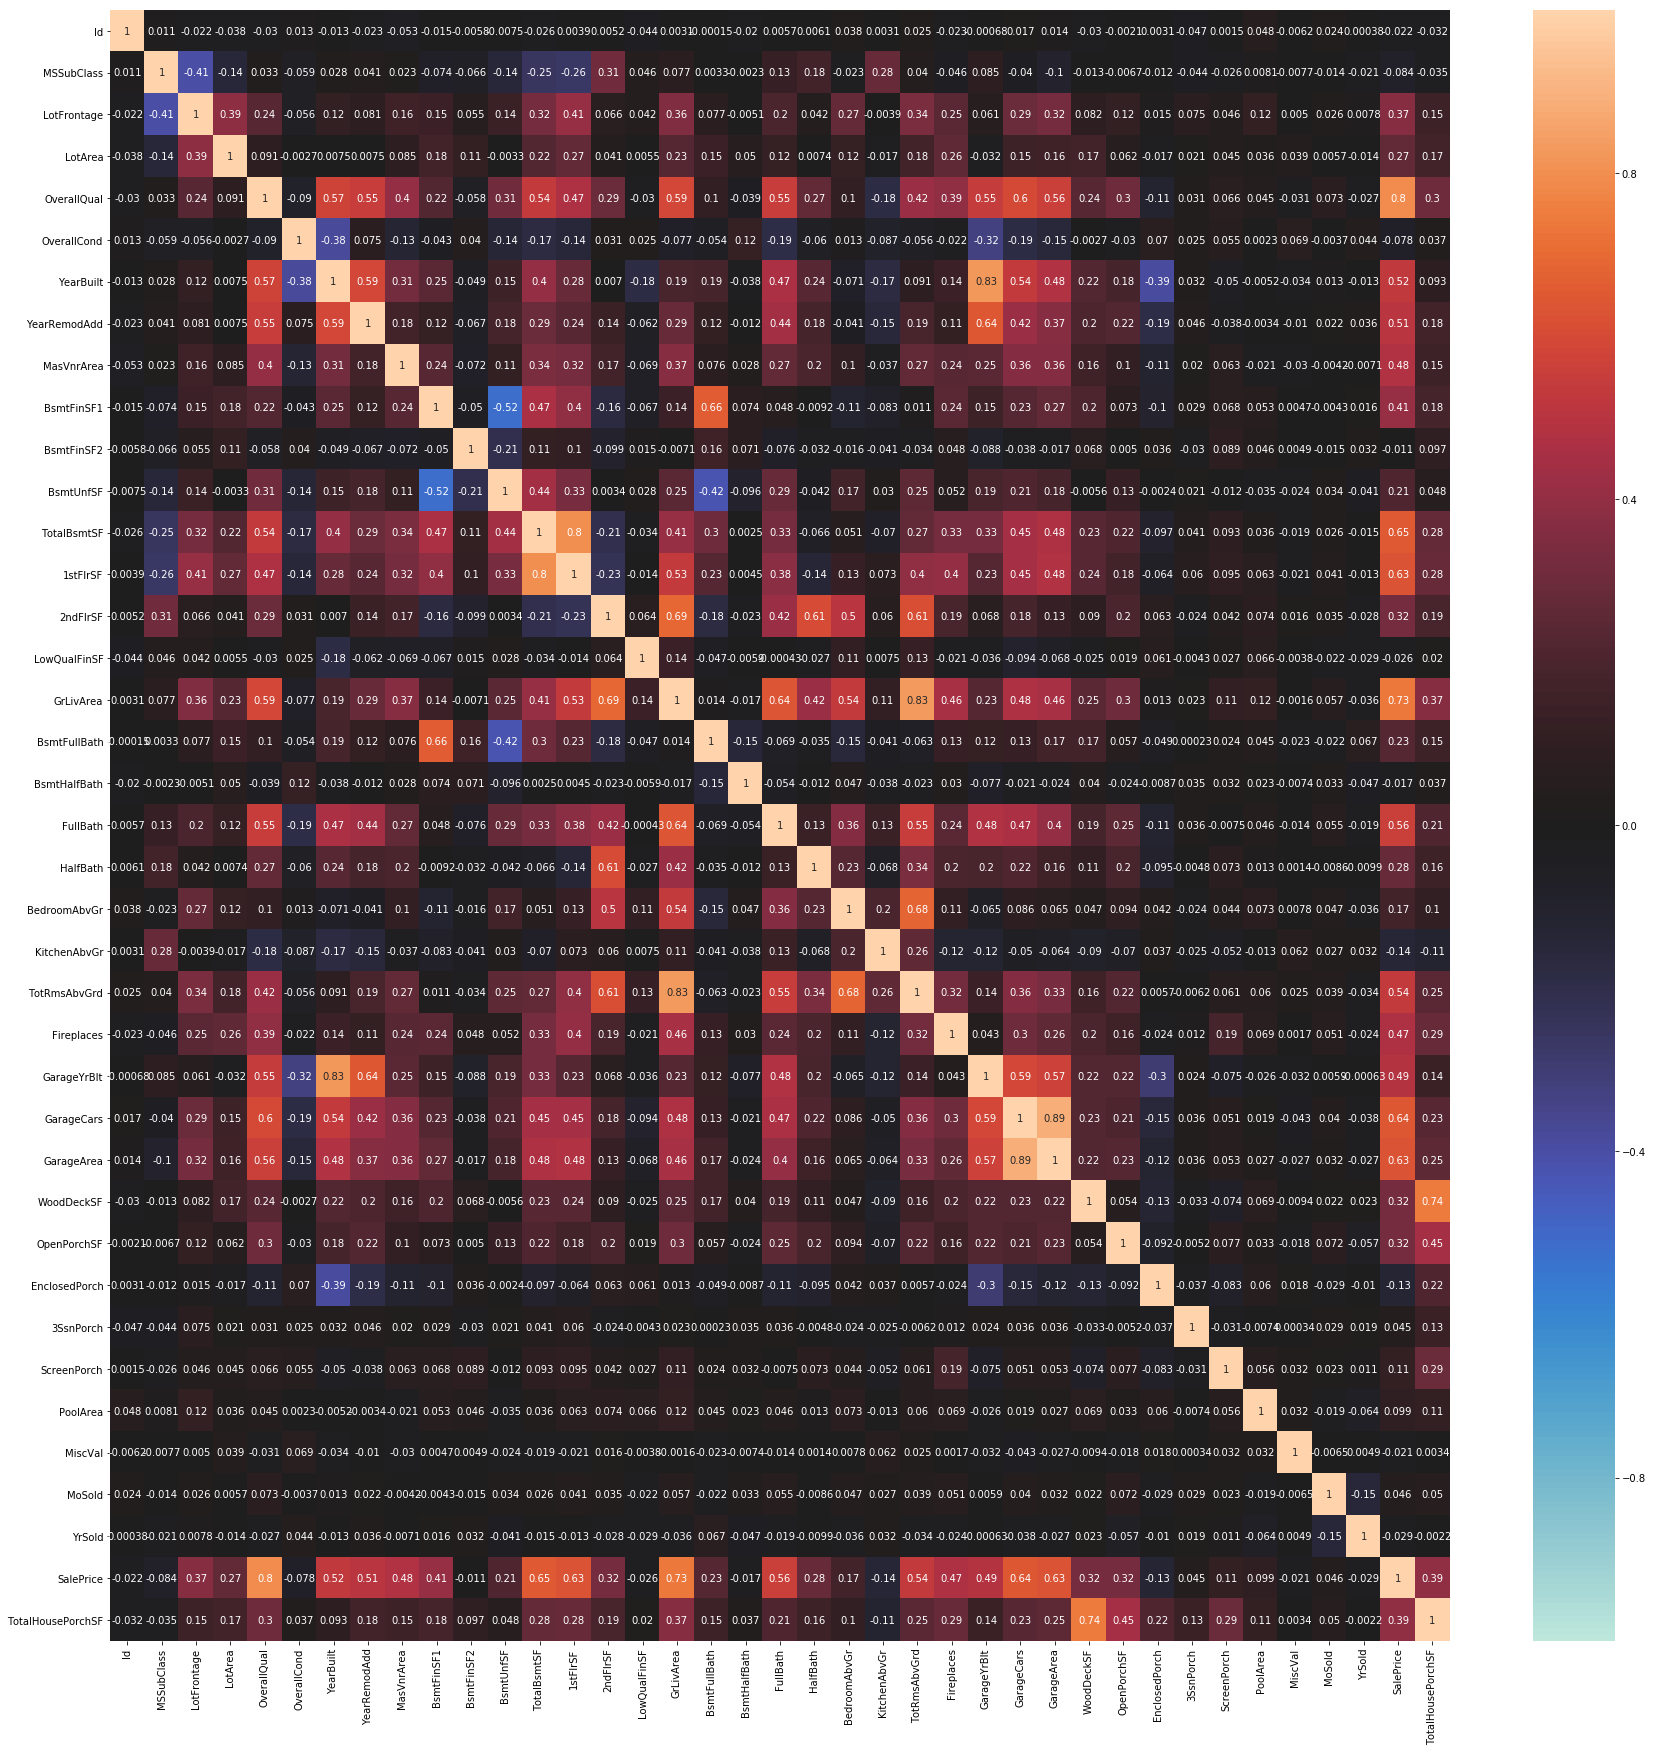

In [39]:
#相関係数行列の可視化
fig, ax = plt.subplots(1,1,figsize=(30, 30))
sns.heatmap(df_train.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

<p>相関係数が絶対値で0.8を超えているものはほぼ確実に多重共線性を引き起こすので、特徴量から削除します。4ペアあります<br />
落とす際は、目的変数であるSalePriceに対しての相関係数が低いものから順に落としていきます。<br />
この場合落とすのは1stFlrSF, TotRmsAbdGrd, GarageArea, GarageYrBltの4つを落とします。</p>


In [40]:
df_all.drop(['1stFlrSF','GarageArea','TotRmsAbvGrd', 'GarageYrBlt'], axis=1, inplace=True)

<h3 id="outline__4">説明変数・目的変数の対数変換</h3>

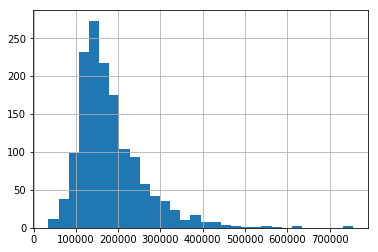

In [41]:
df_train["SalePrice"].hist(bins=30)

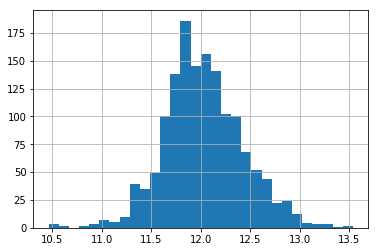

In [42]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
#対数変換後の分布を確認
df_train["SalePrice"].hist(bins=30)

In [43]:
#カテゴリカルでない特徴量
non_categoricals = df_all.dtypes[df_all.dtypes != "object"].index
skewed_feats = df_train[non_categoricals].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.6].index
#歪度0.7より大きい特徴量を対数変換
df_all[skewed_feats] = np.log1p(df_all[skewed_feats])

In [44]:
#One Hot Encoding
df_all = pd.get_dummies(df_all)
#欠損値を平均値で補完
df_all = df_all.fillna(df_all.mean())

#### ラッソ回帰と勾配ブースティングのスタッキング

In [45]:
#学習データ、テストデータに分割
X = df_all[:df_train.shape[0]]
X_for_test = df_all[df_train.shape[0]:]
y = df_train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)

In [46]:
reg = Lasso(alpha=0.0004)
reg.fit(X_train, y_train)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [47]:
y_pred = reg.predict(X_test)
print("ラッソ回帰でのRMSE:",np.sqrt(mean_squared_error(y_pred, y_test)))

ラッソ回帰でのRMSE: 0.1146734601159359


In [48]:
lgb_train = lgb.Dataset(X_train,y_train)

In [49]:
params = {'task': 'train','boosting_type': 'gbdt','objective': 'regression','metric': {'l2'},'num_leaves': 256,
'learning_rate': 0.01,'num_iterations':2000,'feature_fraction': 0.4,'bagging_fraction': 0.7,'bagging_freq': 5}
gbm = lgb.train(params, lgb_train, num_boost_round=1500)
y_test_pred_lgb = gbm.predict(np.array(X_test), num_iteration=gbm.best_iteration)
#RMSE
print("LightGBMでのRMSE:",np.sqrt(mean_squared_error(y_test, y_test_pred_lgb)))

LightGBMでのRMSE: 0.11797068612901135


In [50]:
print("LightGBM+Lassoのスタッキング時のRMSE:",np.sqrt(mean_squared_error(y_test, (y_pred*0.7+y_test_pred_lgb*0.3))))

LightGBM+Lassoのスタッキング時のRMSE: 0.11078682015649094


In [51]:
#全データで学習
reg.fit(X, y)
lgb_train_full = lgb.Dataset(X,y)
gbm = lgb.train(params, lgb_train_full, num_boost_round=1500)

In [52]:
#ラッソ・LightGBMの予測及びスタッキング
pred = np.expm1(reg.predict(X_for_test))
pred2 = np.expm1(gbm.predict(X_for_test))
pred3 = (pred*0.7+pred2*0.3)

In [53]:
solution = pd.DataFrame({"id":df_test.Id, "SalePrice":pred3})
solution.to_csv("test_lasso.csv", index = False)